### Imports

In [1]:
import os
import random
import functools
import cv2
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import skimage.io
from joblib import Parallel, delayed

In [3]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

from chestxray.datasets import img_to_tiles

#### Global Constants

### Retrieve the Images

In [4]:
ls -la {PANDA_PATH}/

total 3232
drwxrwxr-x 5 ademyanchuk ademyanchuk   4096 May 16 10:53 ./
drwxr-xr-x 8 ademyanchuk ademyanchuk   4096 Apr 28 13:53 ../
-rw-rw-r-- 1 ademyanchuk ademyanchuk 541440 May  4 22:31 folds.csv
-rw-rw-r-- 1 ademyanchuk ademyanchuk   5140 May  6 19:15 folds_db.csv
-rw-rw-r-- 1 ademyanchuk ademyanchuk    125 Apr 22 02:10 sample_submission.csv
-rw-rw-r-- 1 ademyanchuk ademyanchuk    149 Apr 22 02:10 test.csv
drwxrwxr-x 2 ademyanchuk ademyanchuk 684032 May 11 19:55 tiles32x128x1/
-rw-rw-r-- 1 ademyanchuk ademyanchuk 520203 Apr 22 02:10 train.csv
drwxrwxr-x 2 ademyanchuk ademyanchuk 724992 Apr 28 23:31 train_images/
drwxrwxr-x 2 ademyanchuk ademyanchuk 802816 Apr 28 23:33 train_label_masks/


In [5]:
PANDA_IMGS

PosixPath('/home/ademyanchuk/Projects/ChestXRay/data/Panda/train_images')

In [6]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)

In [7]:
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [8]:
TRAIN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
dtypes: int64(1), object(3)
memory usage: 331.9+ KB


In [9]:
image_count = len(list(PANDA_IMGS.glob('*.tiff')))

In [10]:
# all unique and dataframe corresponds to file count
assert len(TRAIN_DF) == len(set(TRAIN_DF[CFG.img_id_col])) == image_count

In [11]:
def img_path_from_id(folder, image_id, as_string=False, suffix=".tiff"):
    path = folder / (image_id + suffix)
    if as_string:
        return str(path)
    return path

def mask_path_from_id(image_id, as_string=False, suffix="_mask.tiff"):
    path = PANDA_PATH / ("train_label_masks/" + image_id + suffix)
    if as_string:
        return str(path)
    return path

def cls_label_from_id(image_id):
    try:
        return TRAIN_DF.loc[TRAIN_DF[CFG.img_id_col] == image_id,
                            CFG.target_col].values[0]
    except IndexError:
        raise

Radboud: Prostate glands are individually labelled. Valid values are:
- 0: background (non tissue) or unknown
- 1: stroma (connective tissue, non-epithelium tissue)
- 2: healthy (benign) epithelium
- 3: cancerous epithelium (Gleason 3)
- 4: cancerous epithelium (Gleason 4)
- 5: cancerous epithelium (Gleason 5)

Karolinska: Regions are labelled. Valid values are:
- 1: background (non tissue) or unknown
- 2: benign tissue (stroma and epithelium combined)
- 3: cancerous tissue (stroma and epithelium combined)

Biopsy dimensions: (1136, 1120, 3)
Biopsy ISUP grade - 2


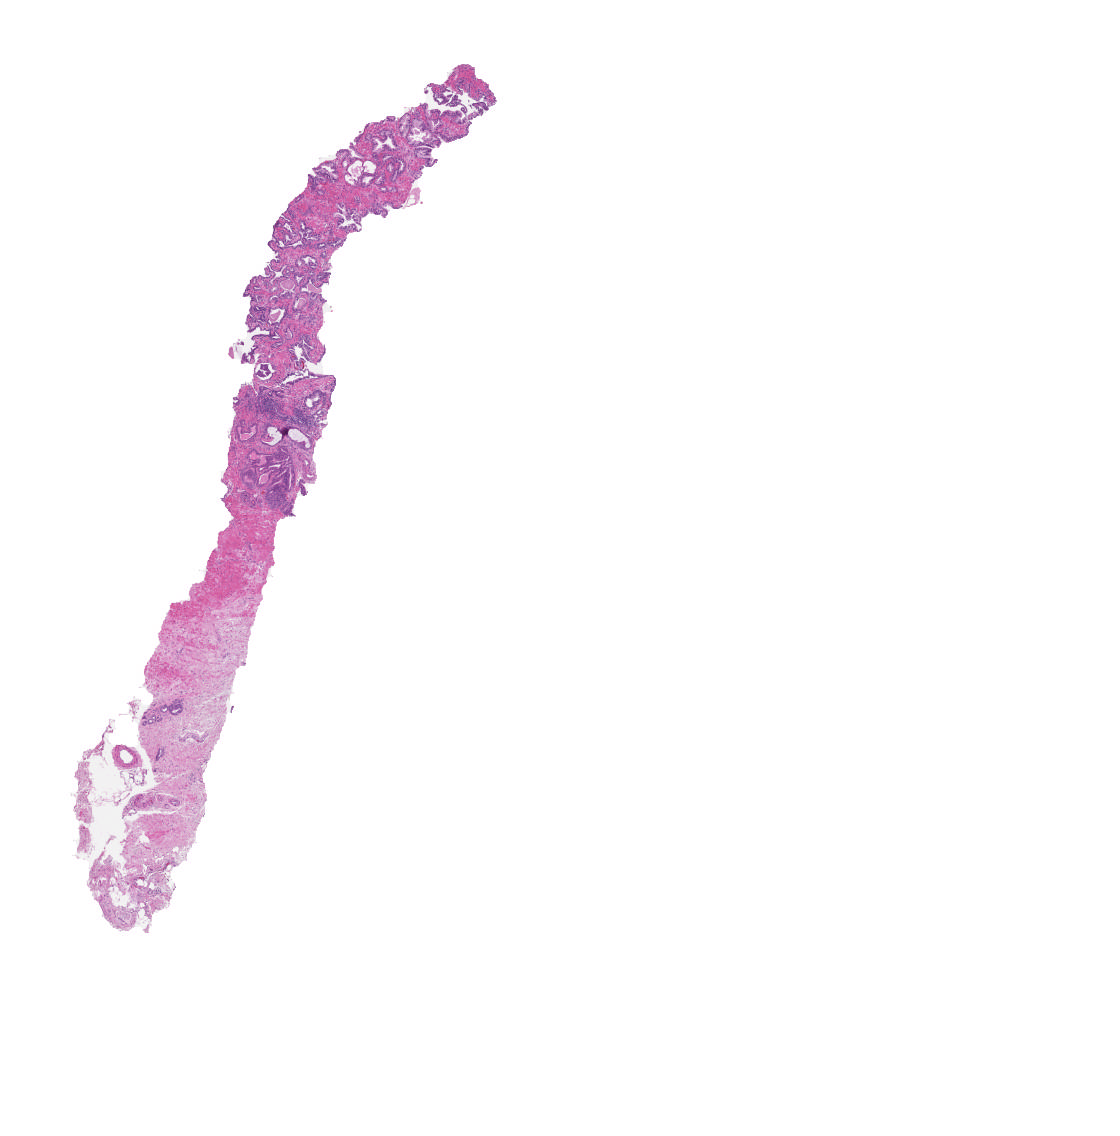

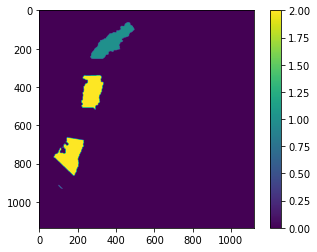

In [12]:
id_sample = TRAIN_DF[CFG.img_id_col].sample(1)

for image_id in id_sample:
    image_path = img_path_from_id(PANDA_IMGS, image_id)
    biopsy = skimage.io.MultiImage(str(image_path))
    print(f"Biopsy dimensions: {biopsy[-1].shape}")
    print(f"Biopsy ISUP grade - {cls_label_from_id(image_id)}")
    display.display(Image.fromarray(biopsy[-1]))
    mask_path = mask_path_from_id(image_id)
    if mask_path.exists():
        mask = skimage.io.MultiImage(str(mask_path))
        mask_level_2 = mask[-1][:,:,0]
        plt.figure()
        plt.imshow(mask_level_2)
        plt.colorbar()
        plt.show()
    del biopsy

### Images to Tiles and Save on Disk

In [13]:
tiles_path = PANDA_PATH/"tiles144x64x1"
tiles_path.mkdir()

In [14]:
# tq_iter = tqdm(TRAIN_DF[CFG.img_id_col], total=len(TRAIN_DF))
# for img_id in tq_iter:
#     src_path = img_path_from_id(PANDA_IMGS, img_id, as_string=True)
#     src_img = skimage.io.MultiImage(src_path)[CFG.tiff_layer]
#     tiles_img = img_to_tiles(src_img, num_tiles=CFG.num_tiles, tile_h=CFG.tile_sz, tile_w=CFG.tile_sz)
#     dest_path = img_path_from_id(tiles_path, img_id, suffix=".png", as_string=True)
#     skimage.io.imsave(dest_path, tiles_img)

In [15]:
def process_img(img_id):
    src_path = img_path_from_id(PANDA_IMGS, img_id, as_string=True)
    src_img = skimage.io.MultiImage(src_path)[CFG.tiff_layer]
    tiles_img = img_to_tiles(src_img, num_tiles=CFG.num_tiles, tile_h=CFG.tile_sz, tile_w=CFG.tile_sz)
    dest_path = img_path_from_id(tiles_path, img_id, suffix=".png", as_string=True)
    skimage.io.imsave(dest_path, tiles_img)

In [16]:
_ = Parallel(n_jobs=-1, verbose=1)(delayed(process_img)(img_id) for img_id in TRAIN_DF[CFG.img_id_col])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 10616 out of 1061

### Load Data as Python Generator

In [14]:
# Toy sample
toy_df = TRAIN_DF.sample(500).copy()

In [15]:
toy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 6863 to 7796
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       500 non-null    object
 1   data_provider  500 non-null    object
 2   isup_grade     500 non-null    int64 
 3   gleason_score  500 non-null    object
dtypes: int64(1), object(3)
memory usage: 19.5+ KB


In [104]:
file_paths = (toy_df[IMAGE_COLUMN]
                .apply(functools.partial(img_path_from_id, as_string=True))
                .values)
labels = toy_df[CLASS_COLUMN].values

In [105]:
def chunker(seq, size):
    """Return a generator chunking `seq` into parts of size `size`"""
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def get_image(path, resize=(IMG_WIDTH, IMG_HEIGHT), level=-1):
    #open with skimage `tiffile`
    biopsy = skimage.io.MultiImage(str(path))
    img = biopsy[level] # smallest tiff level
    # resize here (for now)
    img = cv2.resize(img, resize, interpolation=cv2.INTER_AREA)
    return img

In [142]:
def data_gen(file_paths, labels, shuffle=True, batch_sz=BATCH_SIZE):
    assert len(file_paths) == len(labels)
    while True:
        ids = list(range(len(file_paths)))
        if shuffle:
            random.shuffle(ids)
        for chunk in chunker(ids, batch_sz):
            img_batch = np.array([get_image(path) for path in file_paths[chunk]])
            # TODO: Do not forget preprocessing here!
            img_batch = (img_batch / 255.).astype(np.float32)
            label_batch = labels[chunk]
            yield (img_batch, label_batch)
    

In [143]:
gen = data_gen(file_paths, labels)

In [144]:
img, label = next(iter(gen))

In [145]:
img.shape, img.dtype, label.shape, label.dtype

((16, 512, 512, 3), dtype('float32'), (16,), dtype('int64'))

In [130]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n])
        plt.axis('off')

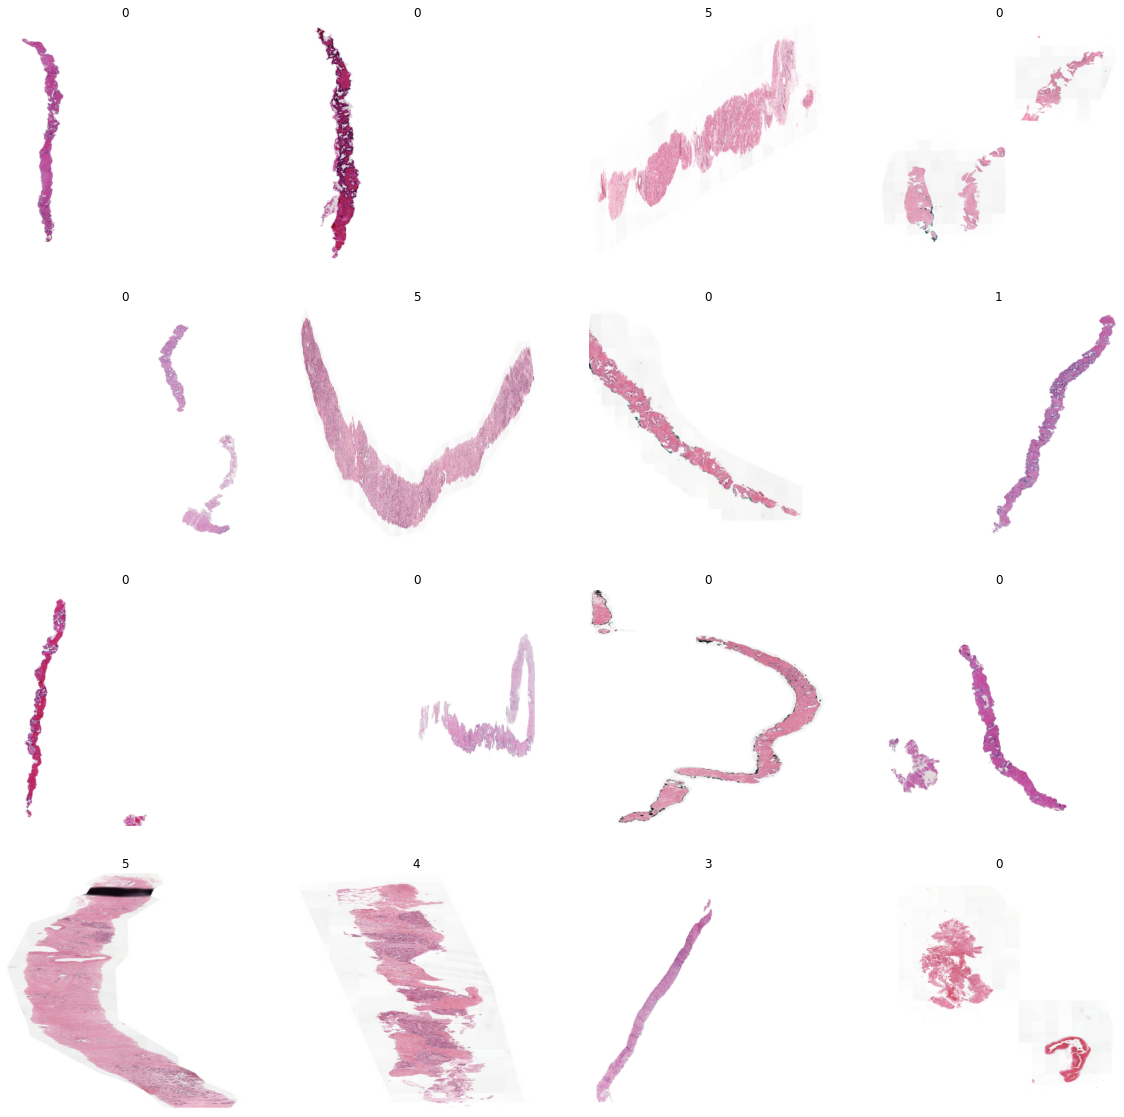

In [148]:
show_batch(img, label)